# Handy Functions in  `xarray`

In this notebook, we will take a look at some handy built-in functions in `xarray`. Be sure to install `xarray` in your own environment or you can uncomment and use the following command:

In [69]:
#!conda install --yes xarray,netCDF4,cartopy

In [70]:
# import packages
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np

## Interpolation

A very common exercise in geospatial analysis is to interpolate data onto different grids. This is particularly true if we have several different data products on different native grids and we want them all to be on the same grid.

`xarray` has some built-in interpolation functions. But, for advanced geospatial regridding, you may want to consider [`xesmf`](https://xesmf.readthedocs.io/en/latest/).

Here is an interpolation example from the [`xarray` documentation](https://xarray.pydata.org/en/stable/user-guide/interpolation.html).

Let's use the `xarray` tutorial data to take a look at the built-in interpolation function.

In [71]:
# load NCEP reanalysis near-surface temperature over North America
ds = xr.tutorial.open_dataset("air_temperature")

In [72]:
# display data
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

Let's plot the first time point to see what it looks like using a built-in `xarray` plotting function:

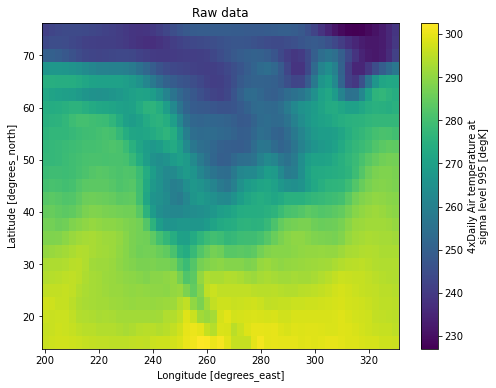

In [43]:
# plot in latitude-longitude space
plt.figure(figsize=(8, 6))

ds.air.isel(time=0).plot()
plt.title("Raw data")
plt.show()

Now, let's interpolate this data onto a higher resolution grid. 

First, we define a new higher resolution set of spatial coordinates:

In [37]:
# Define higher resolution longitude and latitude coordinates
new_lon = np.linspace(ds.lon[0], ds.lon[-1], ds.dims["lon"] * 4)
new_lat = np.linspace(ds.lat[0], ds.lat[-1], ds.dims["lat"] * 4)

Next, we interpolate the low resolution `Dataset` onto the higher resolution coordinates:

In [38]:
dsi = ds.interp(lat=new_lat, lon=new_lon)

Let's take a look at `dsi`:

In [41]:
dsi

<xarray.Dataset>
Dimensions:  (time: 2920, lat: 100, lon: 212)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
  * lat      (lat) float64 75.0 74.39 73.79 73.18 ... 16.82 16.21 15.61 15.0
  * lon      (lon) float64 200.0 200.6 201.2 201.8 ... 328.2 328.8 329.4 330.0
Data variables:
    air      (time, lat, lon) float64 241.2 241.5 241.8 ... 295.9 295.8 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

Finally, let's plot both side-by-side to compare:

Text(0.5, 1.0, 'Interpolated data')

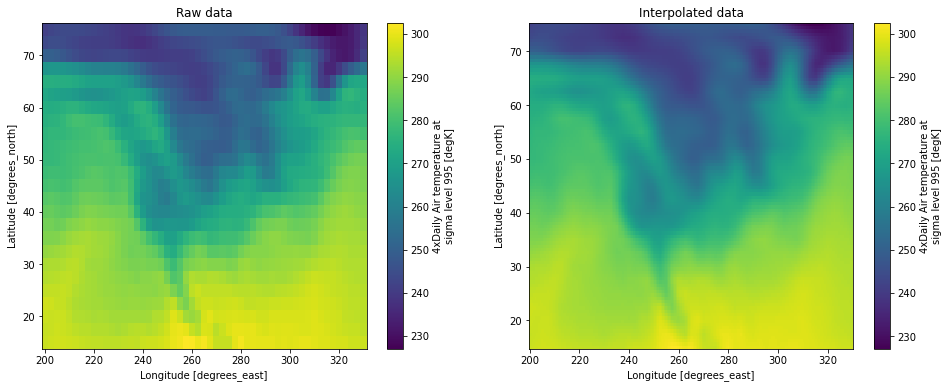

In [39]:
# compare resolutions
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
ds.air.isel(time=0).plot(ax=axes[0])
axes[0].set_title("Raw data")

dsi.air.isel(time=0).plot(ax=axes[1])
axes[1].set_title("Interpolated data")

## Groupby

The `.groupby()` function in `xarray` works in the same way as it does in `pandas`, enabling the “split / apply / combine” workflow on `xarray DataArrays` and `Datasets`. This function is really handy for grouping data, particularly data that has distinct *seasonality*, in time in various ways.

Let's take a look at an example from [Ryan Abernathey's Earth and Environmental Data Science jupyterbook](https://earth-env-data-science.github.io/lectures/xarray/xarray-part2.html).

In this example, he uses the [NOAA Extended Reconstructed Sea Surface Temperature (ERSST) v5 product](https://www.ncei.noaa.gov/products/extended-reconstructed-sst), a widely used and trusted gridded compilation of of historical data going back to 1854.

Since the data is provided via an OPeNDAP server, we can load it directly without downloading anything:

In [48]:
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds = xr.open_dataset(url, drop_variables=['time_bnds'])
ds = ds.sel(time=slice('1961', '2020'))
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 720)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1961-01-01 1961-02-01 ... 2020-12-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes: (12/38)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2022-03-07
    DODS_EXTRA.Unlimited_Dimension:  time

Let's take a quick look at the first time point of the data to make sure it looks reasonable:

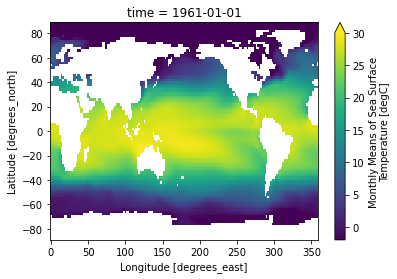

In [49]:
ds.sst[0].plot(vmin=-2, vmax=30)

Suppose we want to compute the 160 year average for each month. We can do this using `.groupby()`.

In [50]:
# groupby month
gb = ds.sst.groupby(ds.time.dt.month)

In [51]:
# alternate groupby month
gb = ds.sst.groupby('time.month')

Now, that we have grouped the data, we can do some simple computations:

In [53]:
# compute 160-year mean for each month
sst_mm = gb.mean(dim='time')
sst_mm

<xarray.DataArray 'sst' (month: 12, lat: 89, lon: 180)>
array([[[-1.8000009, -1.8000009, -1.8000009, ..., -1.8000009,
         -1.8000009, -1.8000009],
        [-1.8000009, -1.8000009, -1.8000009, ..., -1.8000009,
         -1.8000009, -1.8000009],
        [-1.8000009, -1.8000009, -1.8000009, ..., -1.8000009,
         -1.8000009, -1.8000009],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[-1.8000009, -1.8000009, -1.8000009, ..., -1.8000009,
         -1.8000009, -1.8000009],
        [-1.8000009, -1.8000009, -1.8000009, ..., -1.8000009,
         -1.8000009, -1.8000009],
        [-1.8000009, -1.8000009, -1.8000009, ..., -1.8000009,
         -1.8000009, -1.8000009],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[-1.7995498, -1.7996409, -1.7998617, ..., -1.7997952,
         -1.7996738, -1.7995456],
        [-1.7996063, -1.7997835, -1.8000009, ..., -1.8000009,
         -1.7998261, -1.7996305],
        [-1.8000009, -1.8000009, -1.8000009, ..., -1.8000009,
         -1.8000009, -1.8000009],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

The same operation can be done using `.groupby().apply()`:

In [55]:
def time_mean(a):
    return a.mean(dim='time')

sst_mm = gb.apply(time_mean)

Let's plot our data as a function of month and latitude (taking an average across all longitudes - this is called a *zonal mean*)

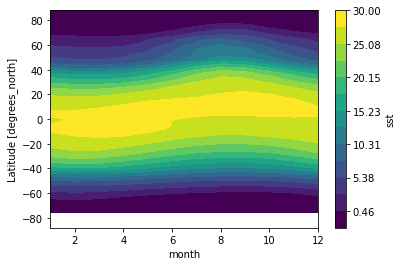

In [61]:
# zonal mean monthly climatology of SST
sst_mm.mean(dim='lon').transpose().plot.contourf(levels=14, vmin=-2, vmax=30)

### Simple Filtering

The seasonal cycle can often be the largest source of variability in Earth and environmental data, so we often want to remove this to isolate other, often more interesting, frequencies.

We can use `.groupby()` to help us with this. First, let's take a look at how large the seasonal cycle in SST is.

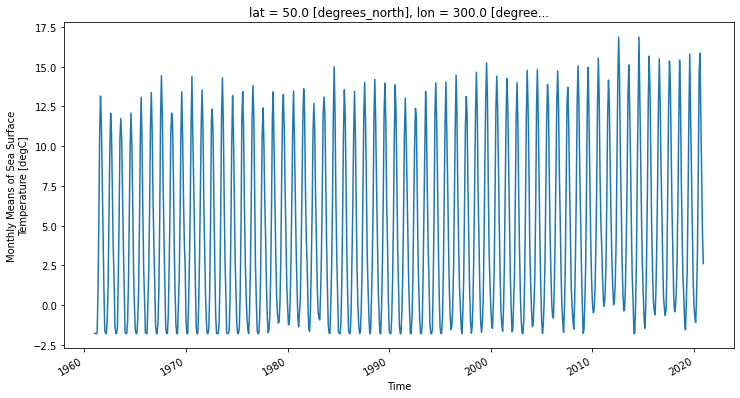

In [64]:
# plot time series for one lat/lon location
plt.figure(figsize=(12,6))
ds.sst.sel(lon=300, lat=50).plot()

The amplitude of the seasonal cycle is quite substantial and it is hard to detect the long-term trend. Let's remove this seasonal cycle using a simple filtering technique. We will subtract the 160-year monthly means, so that all that remains is the deviation from this long-term average.

In [65]:
# subtract long-term average for each month
ds_anom = gb - gb.mean(dim='time')
ds_anom

<xarray.DataArray 'sst' (time: 720, lat: 89, lon: 180)>
array([[[ 9.5367432e-07,  9.5367432e-07,  9.5367432e-07, ...,
          9.5367432e-07,  9.5367432e-07,  9.5367432e-07],
        [ 9.5367432e-07,  9.5367432e-07,  9.5367432e-07, ...,
          9.5367432e-07,  9.5367432e-07,  9.5367432e-07],
        [ 9.5367432e-07,  9.5367432e-07,  9.5367432e-07, ...,
          9.5367432e-07,  9.5367432e-07,  9.5367432e-07],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[ 9.5367432e-07,  9.5367432e-07,  9.5367432e-07, ...,
          9.5367432e-07,  9.5367432e-07,  9.5367432e-07],
        [ 9.5367432e-07,  9.5367432e-07,  9.5367432e-07, ...,
          9.5367432e-07,  9.5367432e-07,  9.5367432e-07],
        [ 9.5367432e-07,  9.5367432e-07,  9.5367432e-07, ...,
          9.5367432e-07,  9.5367432e-07,  9.5367432e-07],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[-4.5013428e-04, -3.5905838e-04, -1.3828278e-04, ...,
         -2.0480156e-04, -3.2615662e-04, -4.5430660e-04],
        [-3.9362907e-04, -2.1648407e-04,  9.5367432e-07, ...,
          9.5367432e-07, -1.7380714e-04, -3.6942959e-04],
        [ 9.5367432e-07,  9.5367432e-07,  9.5367432e-07, ...,
          9.5367432e-07,  9.5367432e-07,  9.5367432e-07],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1961-01-01 1961-02-01 ... 2020-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

Note that the time dimension is the same size as the original data. Let's see how our time series plot has changed.

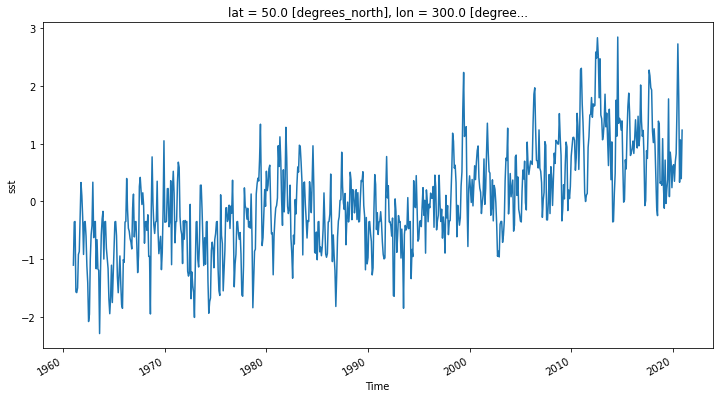

In [67]:
# plot anomaly time series for one lat/lon location
plt.figure(figsize=(12,6))
ds_anom.sel(lon=300, lat=50).plot()

`xarray` has many other built-in functions (borrowing from `numpy`, `scipy` and `pandas`). 

Here are a couple of useful examples:
- [Calculating seasonal averages](https://xarray.pydata.org/en/stable/examples/monthly-means.html)
- [Area-weighting on a sphere](https://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html)